# Copy Task Using NTM

Now we will see, how to perform copy tasks using NTM. The goal of the copy task is to see how NTM stores and recall the sequence of arbitrary length. We will feed the network a random sequence along with a marker indicating the end of a sequence. It has to learn to output the given input sequence. So, the network will store the input sequence to the memory and then it will read back from the memory. 

First, we will import all the necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import argparse
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
%matplotlib inline

Now, we will define a class NTMCell where we will implement our neural turing machine. 

In [2]:
class NTMCell():
    def __init__(self, rnn_size, memory_size, memory_vector_dim, read_head_num, write_head_num,
                 addressing_mode='content_and_location', shift_range=1, reuse=False, output_dim=None):
        
        #initialize all the variables
        self.rnn_size = rnn_size
        self.memory_size = memory_size
        self.memory_vector_dim = memory_vector_dim
        self.read_head_num = read_head_num
        self.write_head_num = write_head_num
        self.addressing_mode = addressing_mode
        self.reuse = reuse
        self.step = 0
        self.output_dim = output_dim
        self.shift_range = shift_range
        
        #initialize controller as the basic rnn cell
        self.controller = tf.nn.rnn_cell.BasicRNNCell(self.rnn_size)

        
        
    def __call__(self, x, prev_state):
        
        
        prev_read_vector_list = prev_state['read_vector_list']  
        prev_controller_state = prev_state['controller_state']     
    
        controller_input = tf.concat([x] + prev_read_vector_list, axis=1)
        
        #next we pass the controller which is the RNN cell, the controller_input and prev_controller_state
        with tf.variable_scope('controller', reuse=self.reuse):
            controller_output, controller_state = self.controller(controller_input, prev_controller_state)

        #initialize read and write heads    
        num_parameters_per_head = self.memory_vector_dim + 1 + 1 + (self.shift_range * 2 + 1) + 1
        num_heads = self.read_head_num + self.write_head_num
        
        total_parameter_num = num_parameters_per_head * num_heads + self.memory_vector_dim * 2 * self.write_head_num
        
        #initialize weight matrix and bias and compute the parameters
        with tf.variable_scope("o2p", reuse=(self.step > 0) or self.reuse):
            o2p_w = tf.get_variable('o2p_w', [controller_output.get_shape()[1], total_parameter_num],
                                    initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))
            o2p_b = tf.get_variable('o2p_b', [total_parameter_num],
                                    initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))
            parameters = tf.nn.xw_plus_b(controller_output, o2p_w, o2p_b)
            
            
        head_parameter_list = tf.split(parameters[:, :num_parameters_per_head * num_heads], num_heads, axis=1)
        
        erase_add_list = tf.split(parameters[:, num_parameters_per_head * num_heads:], 2 * self.write_head_num, axis=1)

        
        #previous write weight vector
        prev_w_list = prev_state['w_list'] 
        
        #previous Memory
        prev_M = prev_state['M']
        
        w_list = []
        p_list = []
        
        
        #now, we will initialize some of the important parameters that we use for addressing. 
        for i, head_parameter in enumerate(head_parameter_list):

            #key vector
            k = tf.tanh(head_parameter[:, 0:self.memory_vector_dim])
            
            #key strength(beta)
            beta = tf.sigmoid(head_parameter[:, self.memory_vector_dim]) * 10  
            
            #interpolation gate
            g = tf.sigmoid(head_parameter[:, self.memory_vector_dim + 1])
            
            #shift matrix  
            s = tf.nn.softmax(
                head_parameter[:, self.memory_vector_dim + 2:self.memory_vector_dim + 2 + (self.shift_range * 2 + 1)]
            )
            
            #sharpening factor
            gamma = tf.log(tf.exp(head_parameter[:, -1]) + 1) + 1
            
            with tf.variable_scope('addressing_head_%d' % i):
                w = self.addressing(k, beta, g, s, gamma, prev_M, prev_w_list[i]) 

            w_list.append(w)
            p_list.append({'k': k, 'beta': beta, 'g': g, 's': s, 'gamma': gamma})

        
        
        #We basically perform two important operations in NTM one is read and other is write operation.
    
        
        #A. Read Operation:
            # read operation is the linear combination  of weights and memory. 
        
        #select the head to read from
        read_w_list = w_list[:self.read_head_num]
        
        
        read_vector_list = []
        for i in range(self.read_head_num):  
            #linear combination  of the weights and memory
            read_vector = tf.reduce_sum(tf.expand_dims(read_w_list[i], dim=2) * prev_M, axis=1)
            read_vector_list.append(read_vector)
            

        #B. Write Operation
        
            #Unlike read operation, write operation consists of two steps - erase and add. 
        
        #select the head to write
        write_w_list = w_list[self.read_head_num:]
        M = prev_M
        for i in range(self.write_head_num):
            
            #the erase vector will be multipled with weight vector to denote which location to erase 
            w = tf.expand_dims(write_w_list[i], axis=2)
            erase_vector = tf.expand_dims(tf.sigmoid(erase_add_list[i * 2]), axis=1)
            
            #next we perform the add operation
            add_vector = tf.expand_dims(tf.tanh(erase_add_list[i * 2 + 1]), axis=1)
            M = M * (tf.ones(M.get_shape()) - tf.matmul(w, erase_vector)) + tf.matmul(w, add_vector)
            
    
        
        #controller output
        if not self.output_dim:
            output_dim = x.get_shape()[1]
        else:
            output_dim = self.output_dim
            
        with tf.variable_scope("o2o", reuse=(self.step > 0) or self.reuse):
            o2o_w = tf.get_variable('o2o_w', [controller_output.get_shape()[1], output_dim],
                                    initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))
            o2o_b = tf.get_variable('o2o_b', [output_dim],
                                    initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))
            NTM_output = tf.nn.xw_plus_b(controller_output, o2o_w, o2o_b)

        state = {
            'controller_state': controller_state,
            'read_vector_list': read_vector_list,
            'w_list': w_list,
            'p_list': p_list,
            'M': M
        }

        self.step += 1
        
        return NTM_output, state

    
    
    def addressing(self, k, beta, g, s, gamma, prev_M, prev_w):
        """
        We will implement two different addressing mechanisms,
        
        1. Content-based
        2. Location-based
            2.1. Interpolation
            2.2. Convolutional Shift
            2.3. Sharpening
        """
       
        
        #1. Content based addressing
        
        #contoller returns a key vector K that is compared with the each row in the memory M using cosine similarity
        k = tf.expand_dims(k, axis=2)
        inner_product = tf.matmul(prev_M, k)
        
        k_norm = tf.sqrt(tf.reduce_sum(tf.square(k), axis=1, keepdims=True))
        M_norm = tf.sqrt(tf.reduce_sum(tf.square(prev_M), axis=2, keepdims=True))
        norm_product = M_norm * k_norm
        
        #Compute cosine similarity
        K = tf.squeeze(inner_product / (norm_product + 1e-8))                     
    
        #now, we produce the normalized weight vector based on the similairty and the key strength (beta)
        #beta is used for adjusting the precision on the head focus
        
        K_amplified = tf.exp(tf.expand_dims(beta, axis=1) * K)
        w_c = K_amplified / tf.reduce_sum(K_amplified, axis=1, keepdims=True)       
    

        if self.addressing_mode == 'content':                                   
            return w_c

        
        #2. Location based addressing
        
        #location based addressing involves three other steps,
        #2.1 Interpolation
        #2.2 Convolutional Shift
        #2.3 Sharpening

        
        #2.1 Interpolation 
        
        #The first step in the location based addressing is the interpolation.
        #It is used to decide whether we should use the weights we obtained at the previous time step  or
        #we should use the weights obtained through content based addressing. 
        #But how do we decide that? We use a new scalar parameter which is used for determining
        #which weights we should use. 

        
        g = tf.expand_dims(g, axis=1)
        w_g = g * w_c + (1 - g) * prev_w                                       
        
        
        #2.2 Convolutional Shift
        #The next step is called convolution shit. It is used for moving the head position.
        #i.e it is used for shifting the focus from one location to the another. 
        
        s = tf.concat([s[:, :self.shift_range + 1],
                       tf.zeros([s.get_shape()[0], self.memory_size - (self.shift_range * 2 + 1)]),
                       s[:, -self.shift_range:]], axis=1)
        
        t = tf.concat([tf.reverse(s, axis=[1]), tf.reverse(s, axis=[1])], axis=1)
        
        s_matrix = tf.stack(
            [t[:, self.memory_size - i - 1:self.memory_size * 2 - i - 1] for i in range(self.memory_size)],
            axis=1
        )
        
        w_ = tf.reduce_sum(tf.expand_dims(w_g, axis=1) * s_matrix, axis=2)      # eq (8)
        
        

        
        #2.3 Sharpening
                
        #The final step is sharpening. As a result of the convolutional shift, the weights will not be sharp.
        #i.e because of the shift, weights focused at a single location will be dispersed into other locations.
        #To mitigate this effect, we perform sharpening. 
        #We use another parameter called  gamma to perform sharpening and it can be expressed as,

        
        w_sharpen = tf.pow(w_, tf.expand_dims(gamma, axis=1))
        w = w_sharpen / tf.reduce_sum(w_sharpen, axis=1, keepdims=True)

        return w

    
    
    #next we define the function called zero state for initializing all the states - 
    #controller state, read vector, weights and memory
    
    def zero_state(self, batch_size, dtype):
        def expand(x, dim, N):
            return tf.concat([tf.expand_dims(x, dim) for _ in range(N)], axis=dim)

        with tf.variable_scope('init', reuse=self.reuse):
            state = {
                'controller_state': expand(tf.tanh(tf.get_variable('init_state', self.rnn_size,
                                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))),
                                  dim=0, N=batch_size),
                
                'read_vector_list': [expand(tf.nn.softmax(tf.get_variable('init_r_%d' % i, [self.memory_vector_dim],
                                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))),
                                  dim=0, N=batch_size)
                           for i in range(self.read_head_num)],
                
                'w_list': [expand(tf.nn.softmax(tf.get_variable('init_w_%d' % i, [self.memory_size],
                                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))),
                                  dim=0, N=batch_size) if self.addressing_mode == 'content_and_loaction'
                           else tf.zeros([batch_size, self.memory_size])
                           for i in range(self.read_head_num + self.write_head_num)],
                
                'M': expand(tf.tanh(tf.get_variable('init_M', [self.memory_size, self.memory_vector_dim],
                                            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.5))),
                                  dim=0, N=batch_size)
            }
            return state


Next we define a function called generate random sequence which will generate random sequence of length seq_length and we will feed this seqence to the NTM input for the copy task.

In [3]:
def generate_random_strings(batch_size, seq_length, vector_dim):
    return np.random.randint(0, 2, size=[batch_size, seq_length, vector_dim]).astype(np.float32)

Now, we create NTMCopyModel for performing the whole copy task. 

In [4]:
class NTMCopyModel():
    
    def __init__(self, args, seq_length, reuse=False):
        
        #input sequence
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[args.batch_size, seq_length, args.vector_dim])
        
        #output sequence
        self.y = self.x
        
        #end of the sequence
        eof = np.zeros([args.batch_size, args.vector_dim + 1])
        eof[:, args.vector_dim] = np.ones([args.batch_size])
        eof = tf.constant(eof, dtype=tf.float32)
        zero = tf.constant(np.zeros([args.batch_size, args.vector_dim + 1]), dtype=tf.float32)
        
        if args.model == 'LSTM':
            def rnn_cell(rnn_size):
                return tf.nn.rnn_cell.BasicLSTMCell(rnn_size, reuse=reuse)
            cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell(args.rnn_size) for _ in range(args.rnn_num_layers)])
            
            
        elif args.model == 'NTM':
            cell = NTMCell(args.rnn_size, args.memory_size, args.memory_vector_dim, 1, 1,
                                    addressing_mode='content_and_location',
                                    reuse=reuse,
                                    output_dim=args.vector_dim)
        
        #initialize all the states
        state = cell.zero_state(args.batch_size, tf.float32)
        
        self.state_list = [state]
        
        for t in range(seq_length):
            output, state = cell(tf.concat([self.x[:, t, :], np.zeros([args.batch_size, 1])], axis=1), state)
            self.state_list.append(state)
        
        #get the output and states
        output, state = cell(eof, state)
        self.state_list.append(state)

        self.o = []
        
        for t in range(seq_length):
            output, state = cell(zero, state)
            self.o.append(output[:, 0:args.vector_dim])
            self.state_list.append(state)
        
        self.o = tf.sigmoid(tf.transpose(self.o, perm=[1, 0, 2]))

        eps = 1e-8
        
        #calculate loss as cross entropy loss
        self.copy_loss = -tf.reduce_mean(self.y * tf.log(self.o + eps) + (1 - self.y) * tf.log(1 - self.o + eps))
        
        #optimize using RMS prop optimizer
        with tf.variable_scope('optimizer', reuse=reuse):
            self.optimizer = tf.train.RMSPropOptimizer(learning_rate=args.learning_rate, momentum=0.9, decay=0.95)
            gvs = self.optimizer.compute_gradients(self.copy_loss)
            capped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
            self.train_op = self.optimizer.apply_gradients(capped_gvs)
                        
        self.copy_loss_summary = tf.summary.scalar('copy_loss_%d' % seq_length, self.copy_loss)


In [5]:
tf.reset_default_graph()

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--mode', default="train")
parser.add_argument('--restore_training', default=False)
parser.add_argument('--test_seq_length', type=int, default=5)
parser.add_argument('--model', default="NTM")
parser.add_argument('--rnn_size', default=16)
parser.add_argument('--rnn_num_layers', default=3)
parser.add_argument('--max_seq_length', default=5)
parser.add_argument('--memory_size', default=16)
parser.add_argument('--memory_vector_dim', default=5)
parser.add_argument('--batch_size', default=5)
parser.add_argument('--vector_dim', default=8)
parser.add_argument('--shift_range', default=1)
parser.add_argument('--num_epoches', default=100)
parser.add_argument('--learning_rate', default=1e-4)
parser.add_argument('--save_dir', default= os.getcwd())
parser.add_argument('--tensorboard_dir', default=os.getcwd())
args = parser.parse_args(args = [])

Now, let's train the NTM.

In [7]:
def train(args):
    model_list = [NTMCopyModel(args, 1)]
    for seq_length in range(2, args.max_seq_length + 1):
        model_list.append(NTMCopyModel(args, seq_length, reuse=True))

        
    with tf.Session() as sess:
        if args.restore_training:
            saver = tf.train.Saver()
            ckpt = tf.train.get_checkpoint_state(args.save_dir + '/' + args.model)
            saver.restore(sess, ckpt.model_checkpoint_path)
        else:
            saver = tf.train.Saver(tf.global_variables())
            tf.global_variables_initializer().run()
        
        #initialize summary writer for visualizing in tensorboard
        train_writer = tf.summary.FileWriter(args.tensorboard_dir, sess.graph)
        plt.ion()
        plt.show()
    
        for b in range(args.num_epoches):
            
            #initialize the sequence length
            seq_length = np.random.randint(1, args.max_seq_length + 1)
            model = model_list[seq_length - 1]
            
            #generate our random input sequence as an input
            x = generate_random_strings(args.batch_size, seq_length, args.vector_dim)
            
            #feed our input to the model
            feed_dict = {model.x: x}
           
            if b % 100 == 0:        
                p = 0              
                print("First training batch sample",x[p, :, :])
                
                #compute model output
                print("Model output",sess.run(model.o, feed_dict=feed_dict)[p, :, :])
                state_list = sess.run(model.state_list, feed_dict=feed_dict)
                
                
                if args.model == 'NTM':
                    w_plot = []
                    M_plot = np.concatenate([state['M'][p, :, :] for state in state_list])
                    for state in state_list:
                        w_plot.append(np.concatenate([state['w_list'][0][p, :], state['w_list'][1][p, :]]))
                    
                    #plot the weight matrix to see the attention
                    plt.imshow(w_plot, interpolation='nearest', cmap='gray')
                    plt.draw()
                    plt.pause(0.001)
                
                #compute loss
                copy_loss = sess.run(model.copy_loss, feed_dict=feed_dict)
                
                #write to summary
                merged_summary = sess.run(model.copy_loss_summary, feed_dict=feed_dict)
                train_writer.add_summary(merged_summary, b)
                
                print('batches %d, loss %g' % (b, copy_loss))
            else:                   
                sess.run(model.train_op, feed_dict=feed_dict)
                
            #save the model
            if b % 5000 == 0 and b > 0:
                saver.save(sess, args.save_dir + '/' + args.model + '/model.tfmodel', global_step=b)


Instructions for updating:
Use the `axis` argument instead
('First training batch sample', array([[1., 0., 1., 1., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 0., 0., 0., 1., 0.]], dtype=float32))
('Model output', array([[0.41622064, 0.40011194, 0.8426822 , 0.18761651, 0.52241313,
        0.4941342 , 0.58150166, 0.27654198],
       [0.39070413, 0.50569034, 0.6326411 , 0.23488827, 0.6771403 ,
        0.53548634, 0.5629458 , 0.23213845],
       [0.52530485, 0.5213146 , 0.76477057, 0.24487178, 0.6035095 ,
        0.38190985, 0.49055338, 0.36256135],
       [0.4900252 , 0.6046341 , 0.6669247 , 0.27418157, 0.54876125,
        0.38766316, 0.5006444 , 0.33060235]], dtype=float32))


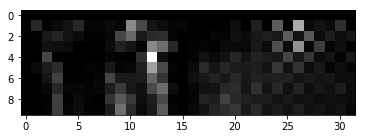

batches 0, loss 0.786682


In [8]:
train(args)

Credits to some parts of the code used in this section goes to [this]( https://github.com/MarkPKCollier/NeuralTuringMachine) github repo. 